<a href="https://colab.research.google.com/github/gargeyibaipa/Data-Science-Projects/blob/main/Impact_of_trips_on_Covid_deaths_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Name : Impact of trips on Covid


### **Set Up** Load libraries for the analysis

**Load packages for the analysis**

In [ ]:
pip install addfips

     |████████████████████████████████| 112kB 5.1MB/s 


In [ ]:
!pip install -U plotly

     |████████████████████████████████| 13.2MB 4.1MB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import addfips as fips
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)
af = fips.AddFIPS()

**Set up spark configurations**

In [ ]:
%%bash
apt-get install openjdk-8-jdk-headless -qq > /dev/null
[ ! -e "$(basename spark-3.0.1-bin-hadoop2.7.tgz)" ] && wget  http://apache.osuosl.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz  
tar xf spark-3.0.1-bin-hadoop2.7.tgz
pip install -q findspark

--2020-12-29 23:50:45--  http://apache.osuosl.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
Resolving apache.osuosl.org (apache.osuosl.org)... 64.50.236.52, 140.211.166.134, 2605:bc80:3010::134, ...
Connecting to apache.osuosl.org (apache.osuosl.org)|64.50.236.52|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 219929956 (210M) [application/x-gzip]
Saving to: ‘spark-3.0.1-bin-hadoop2.7.tgz’

     0K .......... .......... .......... .......... ..........  0%  893K 4m0s
    50K .......... .......... .......... .......... ..........  0% 1.74M 3m0s
   100K .......... .......... .......... .......... ..........  0% 1.75M 2m40s
   150K .......... .......... .......... .......... ..........  0% 1.75M 2m30s
   200K .......... .......... .......... .......... ..........  0%  209M 2m0s
   250K .......... .......... .......... .......... ..........  0%  250M 1m40s
   300K .......... .......... .......... .......... ..........  0% 1.76M 1m43s
   350K .......... ......

In [ ]:
#set up environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

In [ ]:
# start a spark session
import findspark
findspark.init()
from pyspark.sql import SparkSession

# get a spark session. 
spark = SparkSession.builder.master("local[*]").getOrCreate()

**Data Set 1: ** The Trips by Distance data and number of people staying home and not staying home are estimated for the Bureau of Transportation Statistics by the Maryland Transportation Institute and Center for Advanced Transportation Technology Laboratory at the University of Maryland. The travel statistics are produced from an anonymized national panel of mobile device data from multiple sources. All data sources used in the creation of the metrics contain no personal information. Data analysis is conducted at the aggregate national, state, and county levels

In [ ]:
df_trips_people_20=pd.read_csv("https://storage.googleapis.com/sreejit-1/Trips_by_Distance_Fy2020only.csv")
df_trips_people_20.head(5)


Unnamed: 0   Level  ... Number.of.Trips.250.500  Number.of.Trips...500
0     1165655  County  ...                   342.0                   63.0
1     1165656  County  ...                  1513.0                  510.0
2     1165657  County  ...                    63.0                   30.0
3     1165658  County  ...                   135.0                    8.0
4     1165659  County  ...                   499.0                  101.0

[5 rows x 20 columns]

In [ ]:
#check the type of df_trips_people_20
type(df_trips_people_20)
#convert index object to data frame
#df_trips_people_20=df_trips_people_20.to_frame()
type(df_trips_people_20)

pandas.core.frame.DataFrame

**Data Set 2**: Covid death cases from Jan-2020 to Sep-2020 at different geo levels across the USA

In [ ]:
df_covid_deaths_20=pd.read_csv("https://storage.googleapis.com/files.mobibootcamp.com/2020-datafiles/time_series_covid19_deaths_US.csv")
df_covid_deaths_20.head(5)

UID iso2 iso3  code3  ...  9/18/20 9/19/20 9/20/20 9/21/20
0  84001001   US  USA    840  ...       24      24      24      24
1  84001003   US  USA    840  ...       48      49      49      49
2  84001005   US  USA    840  ...        7       7       7       7
3  84001007   US  USA    840  ...       10      10      10      10
4  84001009   US  USA    840  ...       14      14      14      14

[5 rows x 256 columns]

In [ ]:
#check the type of df_covid_deaths_20
type(df_covid_deaths_20)


pandas.core.frame.DataFrame

### Data Cleaning - df_trips_people_20 dataframe

In [ ]:
df_trips_people_20.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996528 entries, 0 to 996527
Data columns (total 20 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unnamed: 0                      996528 non-null  int64  
 1   Level                           996528 non-null  object 
 2   Date                            996528 non-null  object 
 3   State.FIPS                      996216 non-null  float64
 4   State.Postal.Code               996216 non-null  object 
 5   County.FIPS                     980304 non-null  float64
 6   County.Name                     980304 non-null  object 
 7   Population.Staying.at.Home      994041 non-null  float64
 8   Population.Not.Staying.at.Home  994041 non-null  float64
 9   Number.of.Trips                 994041 non-null  float64
 10  Number.of.Trips..1              994041 non-null  float64
 11  Number.of.Trips.1.3             994041 non-null  float64
 12  Number.of.Trips.

In [ ]:
#filter the data to county level
df_trips_people_20=df_trips_people_20[df_trips_people_20['Level']=='County']
df_trips_people_20.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 980304 entries, 0 to 996163
Data columns (total 20 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unnamed: 0                      980304 non-null  int64  
 1   Level                           980304 non-null  object 
 2   Date                            980304 non-null  object 
 3   State.FIPS                      980304 non-null  float64
 4   State.Postal.Code               980304 non-null  object 
 5   County.FIPS                     980304 non-null  float64
 6   County.Name                     980304 non-null  object 
 7   Population.Staying.at.Home      977817 non-null  float64
 8   Population.Not.Staying.at.Home  977817 non-null  float64
 9   Number.of.Trips                 977817 non-null  float64
 10  Number.of.Trips..1              977817 non-null  float64
 11  Number.of.Trips.1.3             977817 non-null  float64
 12  Number.of.Trips.

In [ ]:
# convert dataframe1 columns names to lower case
df_trips_people_20.rename(columns={"Unnamed: 0":"unnamed","Level":"level","Date":"travle_date","State.FIPS":"state_fips","State.Postal.Code":"state_nm","County.FIPS":"county_fips","County.Name":"county_nm","Population.Staying.at.Home":"pop_at_home","Population.Not.Staying.at.Home":"pop_not_home","Number.of.Trips":"total_trips","Number.of.Trips..1":"trips_dis_1","Number.of.Trips.1.3":"trips_dis_1_3",
                                 "Number.of.Trips.3.5":"trips_dis_3_5","Number.of.Trips.5.10":"trips_dis_5_10",
                                 "Number.of.Trips.10.25":"trips_dis_10_25","Number.of.Trips.25.50":"trips_dis_25_50","Number.of.Trips.50.100":"trips_dis_50_100"
                                 ,"Number.of.Trips.100.250":"trips_dis_100_250","Number.of.Trips.250.500":"trips_dis_250_500","Number.of.Trips...500":"trips_dis_500"},inplace=True)
df_trips_people_20.head(5)

unnamed   level  ... trips_dis_250_500  trips_dis_500
0  1165655  County  ...             342.0           63.0
1  1165656  County  ...            1513.0          510.0
2  1165657  County  ...              63.0           30.0
3  1165658  County  ...             135.0            8.0
4  1165659  County  ...             499.0          101.0

[5 rows x 20 columns]

In [ ]:
#look at the missing values in df_trips_people_20
df_trips_people_20_nullcols=df_trips_people_20.columns[df_trips_people_20.isnull().any()].tolist()
df_trips_people_20_nullcols
##there are many fields are having missing values

['pop_at_home',
 'pop_not_home',
 'total_trips',
 'trips_dis_1',
 'trips_dis_1_3',
 'trips_dis_3_5',
 'trips_dis_5_10',
 'trips_dis_10_25',
 'trips_dis_25_50',
 'trips_dis_50_100',
 'trips_dis_100_250',
 'trips_dis_250_500',
 'trips_dis_500']

In [ ]:
#export the data
#from google.colab import drive
#drive.mount('drive')
#df_trips_people_20.to_csv('trips_null.csv')
#df_trips_people_20.to_csv(r'C:\Users\Triveni\OneDrive\Documents\trips_null.csv', index = False)

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
## find out how many records missing the values and % of count

size = df_trips_people_20.shape[0]

print ("Total Size of the dataset : ", size)

total_na = df_trips_people_20.isnull().sum(axis = 0)
print ("Null values : ", total_na)

print ("PERCENTAGE : ", ((total_na/size)*100))

Total Size of the dataset :  980304
Null values :  unnamed                 0
level                   0
travle_date             0
state_fips              0
state_nm                0
county_fips             0
county_nm               0
pop_at_home          2487
pop_not_home         2487
total_trips          2487
trips_dis_1          2487
trips_dis_1_3        2487
trips_dis_3_5        2487
trips_dis_5_10       2487
trips_dis_10_25      2487
trips_dis_25_50      2487
trips_dis_50_100     2487
trips_dis_100_250    2487
trips_dis_250_500    2487
trips_dis_500        2487
dtype: int64
PERCENTAGE :  unnamed              0.000000
level                0.000000
travle_date          0.000000
state_fips           0.000000
state_nm             0.000000
county_fips          0.000000
county_nm            0.000000
pop_at_home          0.253697
pop_not_home         0.253697
total_trips          0.253697
trips_dis_1          0.253697
trips_dis_1_3        0.253697
trips_dis_3_5        0.253697
trips_dis_5_

In [ ]:
#drop null values for all the identified columns which are having nulls
df_trips_people_20 = df_trips_people_20.dropna(axis=0, subset=df_trips_people_20_nullcols)
#check the data after removing nulls
df_trips_people_20.columns[df_trips_people_20.isnull().any()].tolist()

[]

In [ ]:
# check the datatypes and dataframe info
df_trips_people_20.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 977817 entries, 0 to 996163
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   unnamed            977817 non-null  int64  
 1   level              977817 non-null  object 
 2   travle_date        977817 non-null  object 
 3   state_fips         977817 non-null  float64
 4   state_nm           977817 non-null  object 
 5   county_fips        977817 non-null  float64
 6   county_nm          977817 non-null  object 
 7   pop_at_home        977817 non-null  float64
 8   pop_not_home       977817 non-null  float64
 9   total_trips        977817 non-null  float64
 10  trips_dis_1        977817 non-null  float64
 11  trips_dis_1_3      977817 non-null  float64
 12  trips_dis_3_5      977817 non-null  float64
 13  trips_dis_5_10     977817 non-null  float64
 14  trips_dis_10_25    977817 non-null  float64
 15  trips_dis_25_50    977817 non-null  float64
 16  tr

In [ ]:
#convert the date datatype from object to date
df_trips_people_20['travle_date']=df_trips_people_20['travle_date'].astype('datetime64[ns]')
df_trips_people_20.info()
df_trips_people_20.head(4)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 977817 entries, 0 to 996163
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   unnamed            977817 non-null  int64         
 1   level              977817 non-null  object        
 2   travle_date        977817 non-null  datetime64[ns]
 3   state_fips         977817 non-null  float64       
 4   state_nm           977817 non-null  object        
 5   county_fips        977817 non-null  float64       
 6   county_nm          977817 non-null  object        
 7   pop_at_home        977817 non-null  float64       
 8   pop_not_home       977817 non-null  float64       
 9   total_trips        977817 non-null  float64       
 10  trips_dis_1        977817 non-null  float64       
 11  trips_dis_1_3      977817 non-null  float64       
 12  trips_dis_3_5      977817 non-null  float64       
 13  trips_dis_5_10     977817 non-null  float64 

unnamed   level  ... trips_dis_250_500  trips_dis_500
0  1165655  County  ...             342.0           63.0
1  1165656  County  ...            1513.0          510.0
2  1165657  County  ...              63.0           30.0
3  1165658  County  ...             135.0            8.0

[4 rows x 20 columns]

In [ ]:
#drop the columns which are not needed for the analysis
df_trips_people_20.drop(["unnamed","level","state_fips"],inplace=True,axis=1)
df_trips_people_20.head(5)

travle_date state_nm  ...  trips_dis_250_500 trips_dis_500
0  2020-01-01       AL  ...              342.0          63.0
1  2020-01-01       AL  ...             1513.0         510.0
2  2020-01-01       AL  ...               63.0          30.0
3  2020-01-01       AL  ...              135.0           8.0
4  2020-01-01       AL  ...              499.0         101.0

[5 rows x 17 columns]

In [ ]:
#County column - county names are concatinated with "county" so remove the "county" from the values
df_trips_people_20['county_nm'] = df_trips_people_20['county_nm'].str.replace('County','')
df_trips_people_20.head(5)

travle_date state_nm  ...  trips_dis_250_500 trips_dis_500
0  2020-01-01       AL  ...              342.0          63.0
1  2020-01-01       AL  ...             1513.0         510.0
2  2020-01-01       AL  ...               63.0          30.0
3  2020-01-01       AL  ...              135.0           8.0
4  2020-01-01       AL  ...              499.0         101.0

[5 rows x 17 columns]

In [ ]:
##check the duplicates in the data
df_trips_people_20.duplicated(keep='first')
##looks like no duplicates in the data

0         False
1         False
2         False
3         False
4         False
          ...  
996159    False
996160    False
996161    False
996162    False
996163    False
Length: 977817, dtype: bool

### Data Cleaning - df_covid_deaths_20 dataframe

In [ ]:
# convert dataframe2 columns names to lower case
df_covid_deaths_20.columns=df_covid_deaths_20.columns.str.lower()
df_covid_deaths_20.rename(columns={"admin2":"county","province_state":"state","country_region":"country","long_":"long"},inplace=True)
df_covid_deaths_20.head(2)

uid iso2 iso3  code3  ...  9/18/20 9/19/20 9/20/20 9/21/20
0  84001001   US  USA    840  ...       24      24      24      24
1  84001003   US  USA    840  ...       48      49      49      49

[2 rows x 256 columns]

In [ ]:
# unpivot the dataframe for better analysis
df_covid_deaths_20=pd.melt(df_covid_deaths_20,id_vars=["iso2","iso3","uid",'code3', 'fips', 'county', 'state','country', 'lat', 'long', 'combined_key','population'],var_name="date",value_name="count")
df_covid_deaths_20.head(5)

iso2 iso3       uid  code3  ...          combined_key population     date count
0   US  USA  84001001    840  ...  Autauga, Alabama, US      55869  1/22/20     0
1   US  USA  84001003    840  ...  Baldwin, Alabama, US     223234  1/22/20     0
2   US  USA  84001005    840  ...  Barbour, Alabama, US      24686  1/22/20     0
3   US  USA  84001007    840  ...     Bibb, Alabama, US      22394  1/22/20     0
4   US  USA  84001009    840  ...   Blount, Alabama, US      57826  1/22/20     0

[5 rows x 14 columns]

In [ ]:
#display dataframe datatypes and information
df_covid_deaths_20.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814960 entries, 0 to 814959
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   iso2          814960 non-null  object 
 1   iso3          814960 non-null  object 
 2   uid           814960 non-null  int64  
 3   code3         814960 non-null  int64  
 4   fips          812520 non-null  float64
 5   county        813496 non-null  object 
 6   state         814960 non-null  object 
 7   country       814960 non-null  object 
 8   lat           814960 non-null  float64
 9   long          814960 non-null  float64
 10  combined_key  814960 non-null  object 
 11  population    814960 non-null  int64  
 12  date          814960 non-null  object 
 13  count         814960 non-null  int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 87.0+ MB


In [ ]:
#convert date format from object to date
df_covid_deaths_20['date']=df_covid_deaths_20['date'].astype('datetime64[ns]')
df_covid_deaths_20.info()
df_covid_deaths_20.head(4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814960 entries, 0 to 814959
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   iso2          814960 non-null  object        
 1   iso3          814960 non-null  object        
 2   uid           814960 non-null  int64         
 3   code3         814960 non-null  int64         
 4   fips          812520 non-null  float64       
 5   county        813496 non-null  object        
 6   state         814960 non-null  object        
 7   country       814960 non-null  object        
 8   lat           814960 non-null  float64       
 9   long          814960 non-null  float64       
 10  combined_key  814960 non-null  object        
 11  population    814960 non-null  int64         
 12  date          814960 non-null  datetime64[ns]
 13  count         814960 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(4), object(6)
memory usage: 

iso2 iso3       uid  ...  population       date count
0   US  USA  84001001  ...       55869 2020-01-22     0
1   US  USA  84001003  ...      223234 2020-01-22     0
2   US  USA  84001005  ...       24686 2020-01-22     0
3   US  USA  84001007  ...       22394 2020-01-22     0

[4 rows x 14 columns]

In [ ]:
#check for null values
df_covid_deaths_20_nullcols=df_covid_deaths_20.columns[df_covid_deaths_20.isnull().any()].tolist()
df_covid_deaths_20_nullcols

['fips', 'county']

In [ ]:
#check no null value records counts and % of null values

size = df_covid_deaths_20.shape[0]

print ("Total Size of the dataset : ", size)

total_na = df_covid_deaths_20.isnull().sum(axis = 0)
print ("Null values : ", total_na)

print ("PERCENTAGE : ", ((total_na*100)/size)*100)


Total Size of the dataset :  814960
Null values :  iso2               0
iso3               0
uid                0
code3              0
fips            2440
county          1464
state              0
country            0
lat                0
long               0
combined_key       0
population         0
date               0
count              0
dtype: int64
PERCENTAGE :  iso2             0.000000
iso3             0.000000
uid              0.000000
code3            0.000000
fips            29.940120
county          17.964072
state            0.000000
country          0.000000
lat              0.000000
long             0.000000
combined_key     0.000000
population       0.000000
date             0.000000
count            0.000000
dtype: float64


In [ ]:
#drop null values for all the identified columns which are having nulls
df_covid_deaths_20 = df_covid_deaths_20.dropna(axis=0, subset=df_covid_deaths_20_nullcols)
#check the data after removing nulls
df_covid_deaths_20.columns[df_covid_deaths_20.isnull().any()].tolist()


[]

In [ ]:
#drop the columns which are not needed for the analysis
df_covid_deaths_20.drop(["iso2","iso3","uid","code3"],inplace=True,axis=1)
df_covid_deaths_20.head(5)

fips   county    state  ... population       date  count
0  1001.0  Autauga  Alabama  ...      55869 2020-01-22      0
1  1003.0  Baldwin  Alabama  ...     223234 2020-01-22      0
2  1005.0  Barbour  Alabama  ...      24686 2020-01-22      0
3  1007.0     Bibb  Alabama  ...      22394 2020-01-22      0
4  1009.0   Blount  Alabama  ...      57826 2020-01-22      0

[5 rows x 10 columns]

In [ ]:
#export the data
#from google.colab import drive
#drive.mount('drive')
#df_covid_deaths_20.to_csv('covid.csv')
#df_covid_deaths_20.to_csv(r'C:\Users\Triveni\OneDrive\Documents\covid.csv', index = False)

In [ ]:
##check the duplicates in the data
df_covid_deaths_20.duplicated(keep='first')
##looks like no duplicates in the data

0         False
1         False
2         False
3         False
4         False
          ...  
814955    False
814956    False
814957    False
814958    False
814959    False
Length: 811056, dtype: bool

### Combine the dataframes and run some queries

In [ ]:
## Tranfer pandas dataframes to sprak
#df_covid_sp = spark.createDataFrame(df_covid_deaths_20)
#df_trips_sp = spark.createDataFrame(df_trips_people_20)

In [ ]:
## join the two dataframes using spark SQL
#df_covid_trips_sp = df_covid_sp.join(df_trips_sp, (df_covid_sp.date == df_trips_sp.travle_date) & (df_covid_sp.fips == df_trips_sp.county_fips))
#df_covid_trips_sp.show()


In [ ]:
## select the columns from combined dataframe for further to our analysis

#df_covid_trips_sp_st=df_covid_trips_sp.select([c for c in df_covid_trips_sp.columns if c not in {'combined_key','travle_date','state_nm','county_fips','county_nm'}])
#df_covid_trips_sp_st.show()

In [ ]:
#find out which state has more number of trips
#from pyspark.sql.functions import sum as mean
#df_trips_state=df_covid_trips_sp_st.groupBy('state','county').sum('total_trips').alias('total_trips')
#df_trips_state.show()

In [ ]:
## check the record count for both the dataframes
trips_size = df_trips_people_20.shape[0]

print ("Total Size of the dataset : ", trips_size)

covid_size = df_covid_deaths_20.shape[0]

print ("Total Size of the dataset : ", covid_size)


Total Size of the dataset :  977817
Total Size of the dataset :  811056


In [ ]:
df_covid_merge=pd.merge(df_covid_deaths_20,df_trips_people_20,how='left', left_on=['fips','date'], right_on = ['county_fips','travle_date'])
df_covid_merge.head(5)

fips   county  ... trips_dis_250_500 trips_dis_500
0  1001.0  Autauga  ...             146.0          66.0
1  1003.0  Baldwin  ...            1255.0         334.0
2  1005.0  Barbour  ...             106.0          13.0
3  1007.0     Bibb  ...              57.0           5.0
4  1009.0   Blount  ...             487.0          29.0

[5 rows x 27 columns]

In [ ]:
## check the record count after joining both the datasets
join_size = df_covid_merge.shape[0]
print ("Total Size of the dataset : ", join_size)

#looks like some records getting dropped with inner join so we have used left join to merge the data 

Total Size of the dataset :  811056


In [ ]:
#convert dataframe to spark dataframe
#df_covid_merge.head(5)
#pd.df_covid_merge.drop([['combined_key','travle_date','state_nm','county_fips','county_nm']], axis=1,, inplace=True)
df_covid_merge=df_covid_merge.drop(columns=['combined_key','travle_date','state_nm','county_fips','county_nm'])
df_covid_merge.head(5)

fips   county  ... trips_dis_250_500 trips_dis_500
0  1001.0  Autauga  ...             146.0          66.0
1  1003.0  Baldwin  ...            1255.0         334.0
2  1005.0  Barbour  ...             106.0          13.0
3  1007.0     Bibb  ...              57.0           5.0
4  1009.0   Blount  ...             487.0          29.0

[5 rows x 22 columns]

**Query 1 : Find out top states which are having higher/lower trips and covid deaths?**

In [ ]:
## look at the mean value of the drips for each state
df_covid_total_deaths=df_covid_merge.groupby(['state','county'],as_index=False)['count'].mean()
#df_covid_total_deaths['day_count']=df_covid_total_deaths['count'].diff()
df_covid_total_deaths=df_covid_total_deaths.groupby(['state'],as_index=False)['count'].sum()
df_covid_deaths_top=df_covid_total_deaths.nlargest(5,'count')
df_covid_deaths_bottom=df_covid_total_deaths.nsmallest(5,'count')

In [ ]:
#Look at the top three states which are having highest covid deaths
df_covid_deaths_top



state         count
32       New York  20597.463115
30     New Jersey   9178.459016
21  Massachusetts   4788.811475
4      California   4770.385246
13       Illinois   4106.090164

In [ ]:
#look at the bottom 5 states which are having low covid deaths
df_covid_deaths_bottom

state      count
1    Alaska  13.385246
51  Wyoming  14.532787
11   Hawaii  21.737705
26  Montana  31.885246
46  Vermont  37.454918

In [ ]:
#Find the mean value for avg trips for top 5 states..
df_covid_date_avg=df_covid_merge.groupby(['state'],as_index=False)['total_trips'].sum()

df_covid_date_avg.nlargest(5,'total_trips')


state   total_trips
4   California  2.491322e+10
44       Texas  2.025392e+10
32    New York  1.714962e+10
9      Florida  1.542947e+10
13    Illinois  1.051072e+10

In [ ]:
#Find the mean value for avg trips for bottom 5 states..
df_covid_date_avg.nsmallest(5,'total_trips')

state  total_trips
39   Puerto Rico          0.0
51       Wyoming  489067110.0
1         Alaska  516268447.0
46       Vermont  529160373.0
34  North Dakota  549865190.0

**Query 1 Insight : New york,Illinios and calfornia are the states having highest number of trips and covid death counts and are part of Top 5 states.Wyoming,Alaska and vermont had less number of trips and covid death counts and are part of bottom 5 states.**


In [ ]:
## find the mean value of the covid deaths
df_covid_deaths_avg=df_covid_merge.groupby(['state'],as_index=False)['count'].sum()



**Query 2:Find out which month had more number of trips?**

In [ ]:
# Look at the trips by months and findout which month is having higher number of trips?
df_trp_by_month=df_covid_merge.groupby(df_covid_merge['date'],as_index=False)['total_trips'].sum()
df_trp_by_month['month']=df_trp_by_month['date'].dt.month
df_trp_by_month=df_trp_by_month.groupby(df_trp_by_month['month'],as_index=False)['total_trips'].sum()
df_trp_by_month=df_trp_by_month.sort_values(by=['total_trips'], ascending=False)
df_trp_by_month.head(15)

month   total_trips
1      2  3.455528e+10
2      3  3.301087e+10
4      5  3.227984e+10
5      6  3.083162e+10
7      8  2.906786e+10
6      7  2.897197e+10
3      4  2.696669e+10
8      9  1.972738e+10
0      1  1.209943e+10

**Query 2 Insight: Above query results indicates Feb 2020 had more number of trips**

**Query 3: Find out which month shows most number of people stayed at home?**

In [ ]:
# Look at the trips by months and findout which month is having higher number of trips?
df_pop_home_month=df_covid_merge.groupby(df_covid_merge['date'],as_index=False)['pop_at_home'].sum()
df_pop_home_month['month']=df_pop_home_month['date'].dt.month
df_pop_home_month=df_pop_home_month.groupby(df_pop_home_month['month'],as_index=False)['pop_at_home'].sum()
df_pop_home_month=df_pop_home_month.sort_values(by=['pop_at_home'], ascending=False)
df_pop_home_month.head(15)

month   pop_at_home
3      4  2.753262e+09
6      7  2.531626e+09
7      8  2.508985e+09
2      3  2.434090e+09
4      5  2.392496e+09
5      6  2.257317e+09
1      2  1.853621e+09
8      9  1.801783e+09
0      1  6.450730e+08

**Query 3 insight : Results shows that most number of people stayed home in the month of April 2020.**

**Final data frame for EDA**

In [ ]:
df_covid_merge.shape

(811056, 22)

In [ ]:
df_covid_merge

fips      county  ... trips_dis_250_500 trips_dis_500
0        1001.0     Autauga  ...             146.0          66.0
1        1003.0     Baldwin  ...            1255.0         334.0
2        1005.0     Barbour  ...             106.0          13.0
3        1007.0        Bibb  ...              57.0           5.0
4        1009.0      Blount  ...             487.0          29.0
...         ...         ...  ...               ...           ...
811051  56039.0       Teton  ...             444.0         215.0
811052  56041.0       Uinta  ...             367.0         126.0
811053  90056.0  Unassigned  ...               NaN           NaN
811054  56043.0    Washakie  ...              49.0          25.0
811055  56045.0      Weston  ...              59.0          31.0

[811056 rows x 22 columns]

In [ ]:
##look at the summary stastics of the data
df_covid_merge.describe()

fips            lat  ...  trips_dis_250_500  trips_dis_500
count  811056.000000  811056.000000  ...      764482.000000  764482.000000
mean    33064.455475      36.777929  ...         626.299868     388.378972
std     18556.336035       8.925524  ...        1867.989538    1729.007220
min      1001.000000       0.000000  ...           0.000000       0.000000
25%     19084.500000      33.917484  ...          63.000000      14.000000
50%     31016.000000      38.005610  ...         184.000000      54.000000
75%     47129.500000      41.591105  ...         490.750000     189.000000
max     90056.000000      69.314792  ...       83066.000000  125691.000000

[8 rows x 18 columns]

# EDA

Analysis 1: create data frame to analyze trend of covid death cases by month?

Assumption: Number of covid deaths may be increased drastically over the months.

In [ ]:
#create a data frame
df_covid_clean=df_covid_merge
df_covid_date=df_covid_clean.groupby(['date'],as_index=False)['count'].sum()
#df_covid_date=df_covid_date.groupby(['date'],as_index=False)['count'].sum()
df_covid_date.set_index(['date'],inplace=True)
df_covid_date =df_covid_date.resample('M', closed='right', label='right').mean()


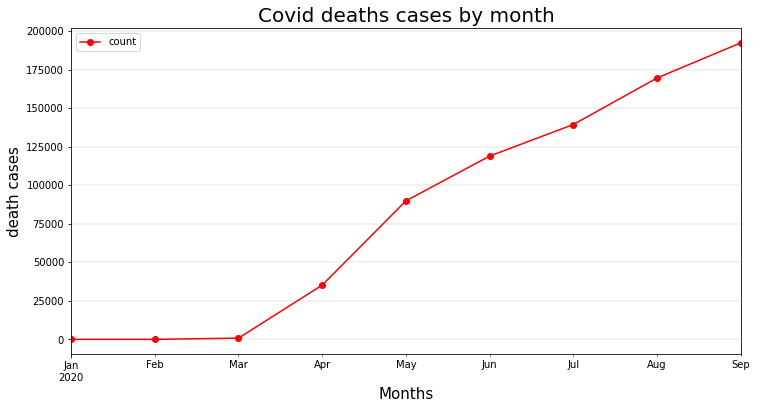

In [ ]:
#plot the to see the trend of covid deaths.
ax = df_covid_date.plot(figsize=(12,6), color='r', marker='o')
ax.set_yticklabels(pd.Series(ax.get_yticks()).map(lambda x: '{:.0f}'.format(x)))
ax.set_title("Covid deaths cases by month",size=20)
ax.set_xlabel("Months",size=15)
ax.set_ylabel("death cases",size=15)
ax.grid(color='grey', linestyle='-', linewidth=0.2)
#print(df_covid_date)

**Insight 1: Above plot indicates,there are no deaths in Feb and March but started increasing rapidly from month of april 2020 across USA**

Analysis 2: What is the week over week change in covid deaths?

Assumption: Based on above analysis,covid deaths may be higher during the weeks of may 2020 and june 2020

In [ ]:
df_covid_month=df_covid_merge.groupby(df_covid_merge['date'],as_index=False)['count'].sum()
df_covid_month['month']=df_covid_month['date'].dt.month
df_covid_month['week']=df_covid_month['date'].dt.isocalendar().week
df_covid_week=df_covid_month.groupby(['month','week'],as_index=False)['count'].mean()
df_covid_week=df_covid_month.groupby(['week'],as_index=False)['count'].mean()
df_covid_week['diff']=df_covid_week['count'].diff()
df_covid_week.sum()

week     7.740000e+02
count    3.178873e+06
diff     1.995450e+05
dtype: float64

Text(0.5, 1.0, 'Covid-19 death cases week over week change')

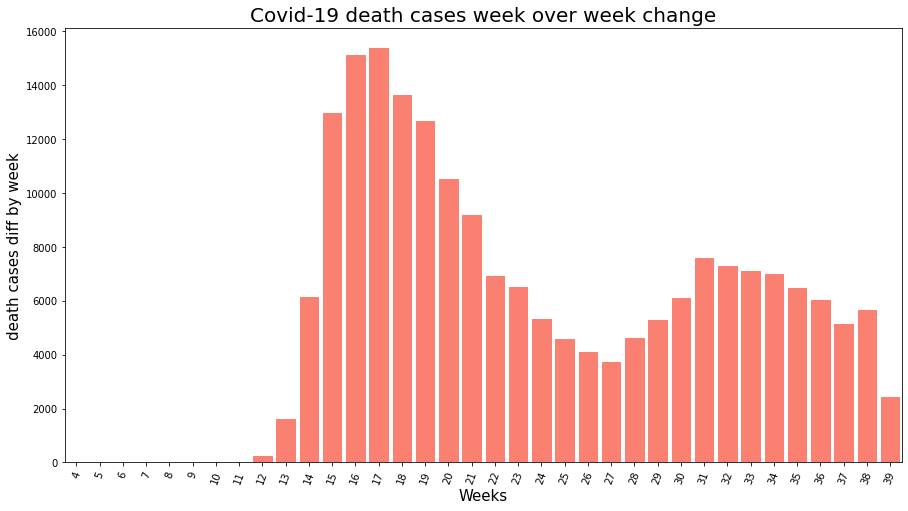

In [ ]:
#look at the splot of week over week changes in the covid deaths
plt.figure(figsize=(15,8))
plt.xticks(rotation=70)
plt_week=sns.barplot(x='week',y='diff',data=df_covid_week,color='grey')
for bar in plt_week.patches:
    if bar.get_height() < 0:
        bar.set_color('red')    
    else:
        bar.set_color('salmon')
plt.xlabel("Weeks", size=15)
plt.ylabel("death cases diff by week", size=15)
plt.title("Covid-19 death cases week over week change",size=20)

**Insight 2 : 1.Above plot indicates,Covid deaths started in week 12 of 2020,peaked to ~15000 in the week of 13.**

**2.Also graph indicates drop in number of deaths from week 22-27 before fluctuates again..**

**3.Week 39 has lowest number of deaths(~2000) at the end of the period..**

Analysis 3: Analyse the covid deaths by date and observe the trend..

Assumption: Based on above anaysis,covid deaths may increase drastically day by day in april and may months. covid deaths may decrease drastically in july and august months

In [ ]:
# look at dataframe for date wise covid deaths
df_covid_date_tr=df_covid_merge.groupby(df_covid_merge['date'],as_index=False)['count'].sum()
df_covid_date_tr['diff']=df_covid_date_tr['count'].diff()
df_covid_date_tr.nlargest(5,'diff')#90151
#if we want to validate the data export to csv
#df_covid_date_tr.to_csv('covid.csv')


date  count    diff
84 2020-04-15  34270  2606.0
76 2020-04-07  16753  2565.0
90 2020-04-21  47150  2546.0
98 2020-04-29  63432  2518.0
92 2020-04-23  52041  2462.0

No handles with labels found to put in legend.


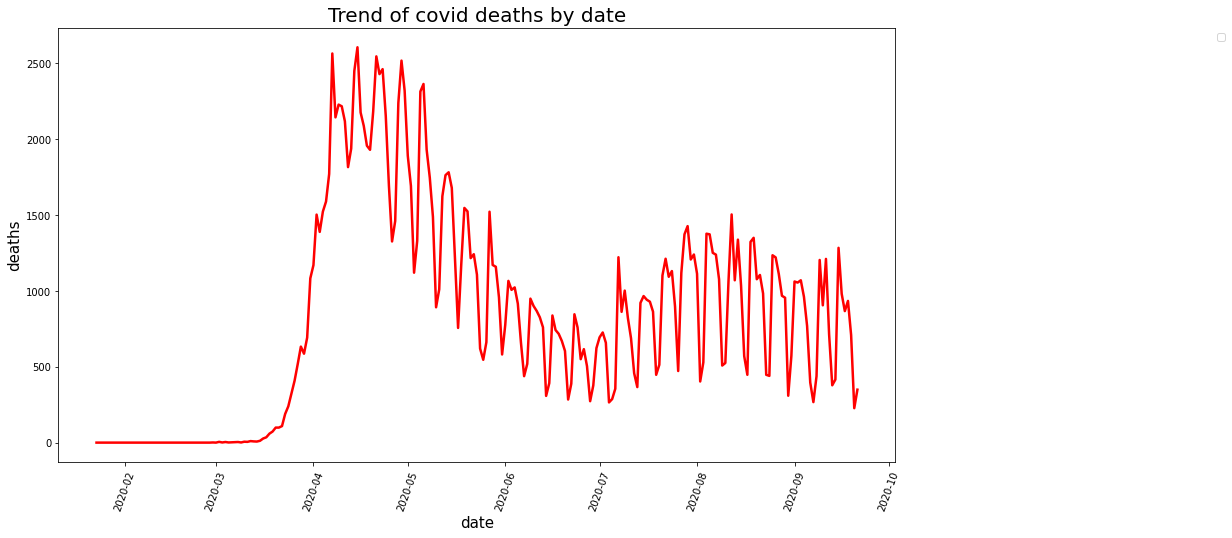

In [ ]:
#plot the to see the trend of covid deaths by date.
plt.figure(figsize=(15,8))
plt.xticks(rotation=70)
plt_box=sns.lineplot(data=df_covid_date_tr, x="date", y="diff",color='red', linewidth=2.5)
plt.xlabel("date", size=15)
plt.ylabel("deaths", size=15)
plt.title("Trend of covid deaths by date",size=20)
plt_box.legend(loc='upper right', bbox_to_anchor=(1.4, 1))

**Insight 3 : As previous analysis indicated,april & may months indicated highest number of covid deaths. 07-April-2020,15-April-2020 are the two dates where we ahve more than 2500 covid deaths.Above plot also indicated covid deaths decreased drastically in jun,jul and august months**

Analysis 4: What is the distribution of covid deaths over the months?

Assumption: Most of the days in the of april and may might have higher deaths.Also,most days in Jun,Jul and Aug might have lower deaths

In [ ]:
#add month to date trend dataframe
df_covid_date_tr['month']=df_covid_date_tr['date'].dt.month
df_covid_date_tr.head(2)

date  count  diff  month
0 2020-01-22      0   NaN      1
1 2020-01-23      0   0.0      1

Text(0.5, 1.0, 'Covid deaths distribution by month')

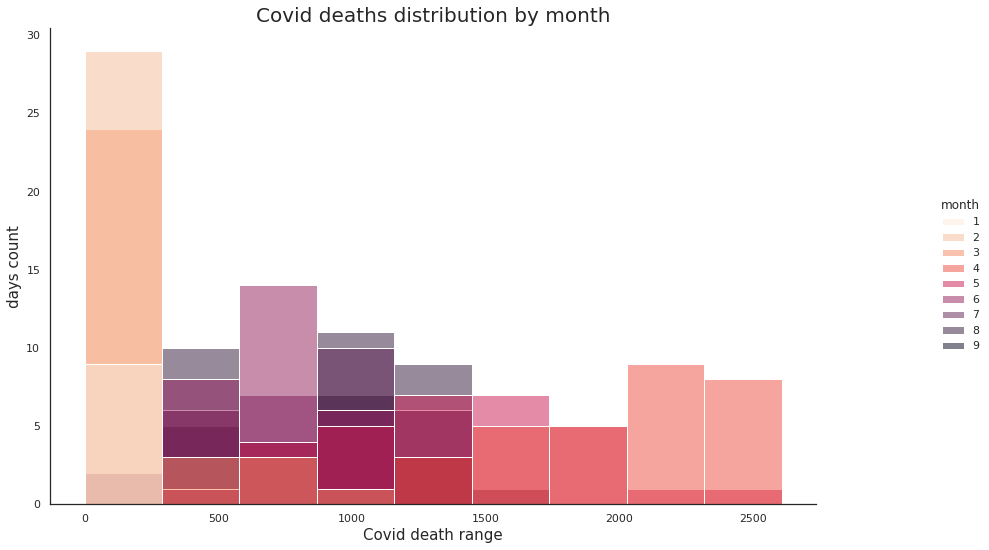

In [ ]:
#plot distributon of covid deaths
plt_box=sns.displot(df_covid_date_tr, x="diff",hue="month",palette="rocket_r")  
plt_box.fig.set_figwidth(15)
plt_box.fig.set_figheight(8)
plt.xlabel("Covid death range", size=15)
plt.ylabel("days count", size=15)
plt.title("Covid deaths distribution by month",size=20)


**Insight 4**:
**1.Most of the days in march and april are having more than 2000 covid cases.**

**2.May month dates are having covid death cases between 500-750.**

**3.Some days in august,september are having covid deaths between 0-500 and other days having above 1000**

Analysis 5: what is the covid deaths variability between the dates over the months?

Assumption: The variability in the number of covid deaths may be lesss between the dates.

Text(0.5, 1.0, 'Box plot - Covid-19 confirmed cases by month/dates')

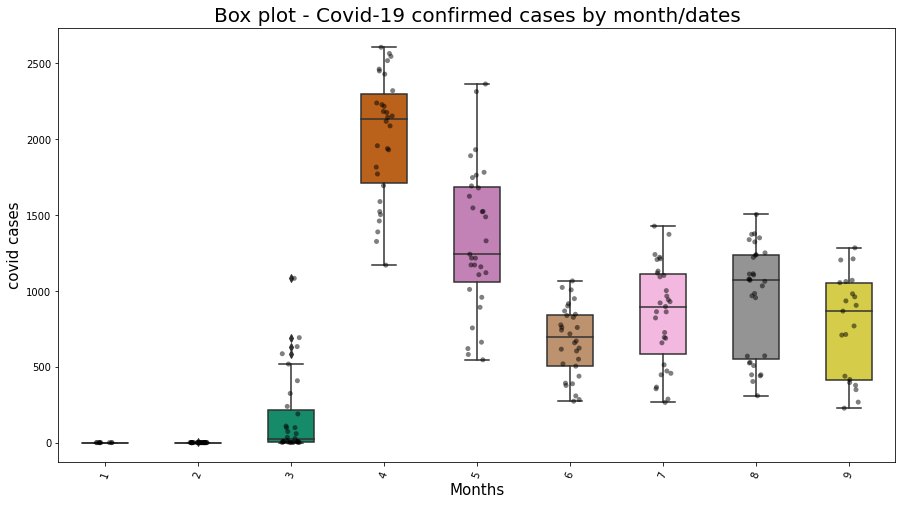

In [ ]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=70)
plt_box=sns.boxplot(y='diff', x='month', 
                   data=df_covid_date_tr, 
                   width=0.5,
                   palette="colorblind")
plt_box=sns.stripplot(y='diff', x='month', 
                   data=df_covid_date_tr, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black')
plt.xlabel("Months", size=15)
plt.ylabel("covid cases", size=15)
plt.title("Box plot - Covid-19 confirmed cases by month/dates",size=20)

**Insight 5: Above plot indicates,more number of dates appeared as outliers in the month of march and april  that means those dates are having higher number covid deaths.But it is not the case with other months like june.
2.there is huge variability in covid deaths in August month.Because we see some dates are having covid deaths below 500 and other dates are having covid deaths are above 1000 but not between**

Analysis 6: How does the number of cases look like in US as of sept 2020

Assumption : Covid deaths may be high where population is very high

In [ ]:
current_feature = "count"
curr_min = min( df_covid_deaths_20["count"])
curr_max = max( df_covid_deaths_20["count"])

In [ ]:
df_test = df_covid_deaths_20[df_covid_deaths_20['date']=='2020-09-20']

In [ ]:
df_test.head(5)

fips   county    state  ... population       date  count
808280  1001.0  Autauga  Alabama  ...      55869 2020-09-20     24
808281  1003.0  Baldwin  Alabama  ...     223234 2020-09-20     49
808282  1005.0  Barbour  Alabama  ...      24686 2020-09-20      7
808283  1007.0     Bibb  Alabama  ...      22394 2020-09-20     10
808284  1009.0   Blount  Alabama  ...      57826 2020-09-20     14

[5 rows x 10 columns]

In [ ]:
df_test['fips'] = df_test['fips'].astype('int64', copy=True)
df_test = df_test[df_test['fips'] < 80000].copy(deep=True)
df_test['fips'] = df_test['fips'].astype('str', copy=True)
df_test['fips'] = df_test['fips'].str.rjust(5, '0')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#Plot map
fig = px.choropleth(df_test, geojson=counties, locations='fips', color=current_feature,
                           color_continuous_scale="Viridis",
                           range_color=(curr_min, 100),
                           scope="usa",
                           labels={current_feature: current_feature}
                          )

fig.update_layout( title_text = 'Covid deaths by county',margin={"r":0,"l":0,"b":0})
fig.show()

**Insights 6: The map above shows the list of states with highest number of deaths up until the month of Sep-2020.We notice that high populous states like CA,NY and MA have higher deaths**

Analysis 7: How covid deaths are related to population of states?

Assumption: There may be a relation between covid deaths and population i.e states with high population may have higher deaths.

In [ ]:
df_covid_deaths_state=df_covid_merge.groupby(['state','county'],as_index=False).agg({'count': ['mean'],'population':['sum']})
#rename columns
df_covid_deaths_state.columns = ['state','county','deaths_mean', 'population']
df_covid_deaths_state.head(5)
df_covid_deaths_state=df_covid_deaths_state.groupby(['state'],as_index=False).agg({'deaths_mean': ['sum'],'population':['sum']})
df_covid_deaths_state.columns = ['state','deaths', 'population']


In [ ]:
##look at the top 5 states where covid deaths are high and thier popilation
df_high_deats_top=df_covid_deaths_state.nlargest(5,'deaths')
df_high_population_top=df_covid_deaths_state.nlargest(5,'population')
df_high_deats_bottom=df_covid_deaths_state.nsmallest(5,'deaths')

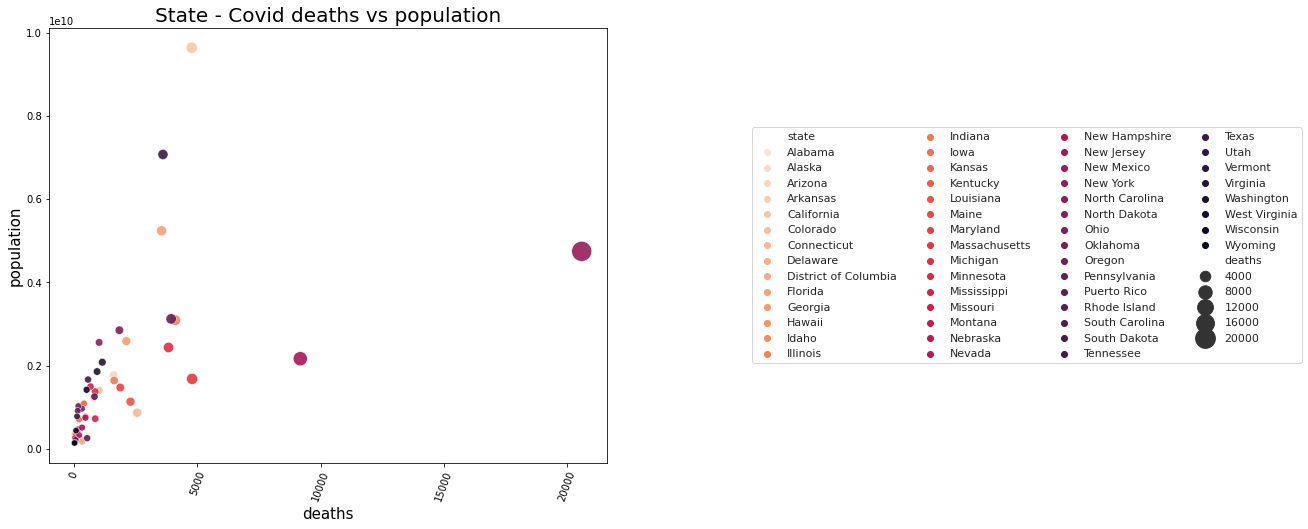

In [ ]:
plt.figure(figsize=(10,8))
plt.xticks(rotation=70)
sns.set_theme(style="white")
plt_sactter=sns.scatterplot(data=df_covid_deaths_state, x="deaths", y="population",hue="state",size="deaths", sizes=(40, 400), alpha=.9, palette="rocket_r")
#plt_sactter=sns.regplot(data=df_covid_deaths_state, x="deaths", y="population")
plt.xlabel("deaths", size=15)
plt.ylabel("population", size=15)
plt.title("State - Covid deaths vs population",size=20)
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=4)

**Insight 7: Contrary to the assumption, the above plot shows no relation between covid deaths and population of states.california is highly populated state but less number of deaths recorded in that state**

Analysis 8: Find out population rate, covid death rates and look for the relationship?

Assumption: Above analysis shows that there is no relation between covid deaths and population count.In this analysis,we assume there may be relation between the covid death rates and population rates of the USA states

In [ ]:
df_covid_deaths_state['Per.pop'] = 100 * df_covid_deaths_state['population']  / df_covid_deaths_state['population'].sum()
df_covid_deaths_state['death rate'] = (df_covid_deaths_state['deaths']/df_covid_deaths_state['population'])*100


In [ ]:
#look at the highest death rate and population of sates
df_covid_deaths_state.nlargest(5,'death rate')

state        deaths  population   Per.pop  death rate
32       New York  20597.463115  4746668884  5.859604    0.000434
30     New Jersey   9178.459016  2167254360  2.675403    0.000424
6     Connecticut   2558.459016   869930028  1.073900    0.000294
21  Massachusetts   4788.811475  1681770732  2.076090    0.000285
40   Rhode Island    529.319672   258484084  0.319090    0.000205

In [ ]:
##look at the death rates for the highest population rate states
df_covid_deaths_state.nlargest(5,'Per.pop')

state        deaths  population    Per.pop  death rate
4     California   4770.385246  9640982412  11.901471    0.000049
44         Texas   3605.307377  7074994964   8.733845    0.000051
9        Florida   3551.045082  5240567828   6.469306    0.000068
32      New York  20597.463115  4746668884   5.859604    0.000434
38  Pennsylvania   3938.450820  3123685316   3.856085    0.000126

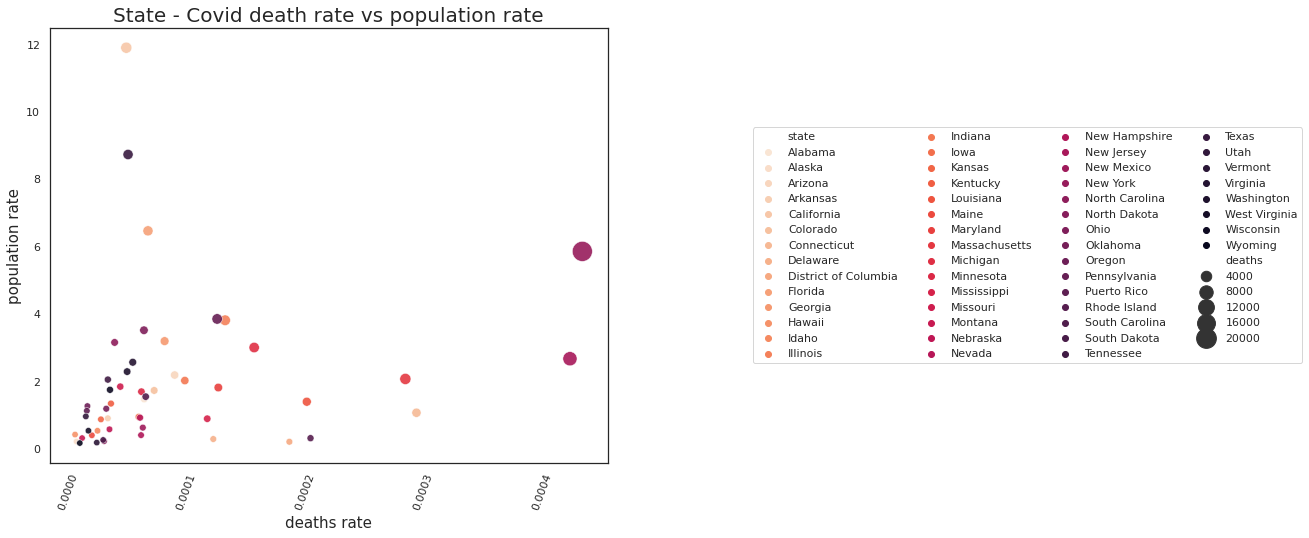

In [ ]:
#plot population rate and death rate
plt.figure(figsize=(10,8))
plt.xticks(rotation=70)
sns.set_theme(style="white")
plt_sactter=sns.scatterplot(data=df_covid_deaths_state, x="death rate", y="Per.pop",hue="state",size="deaths", sizes=(40, 400), alpha=.9, palette="rocket_r")
#sns.relplot(data=df_covid_deaths_state, x="death rate", y="Per.pop",col="state", hue="state", style="state",kind="scatter")
plt.xlabel("deaths rate", size=15)
plt.ylabel("population rate", size=15)
plt.title("State - Covid death rate vs population rate",size=20)
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=4)
#plt.legend(title='state', loc='upper riht', labels=['New York', 'New Jersey'])

**Insight 8: We see highest death rate in new york which is having 6% popuation of USA.But calfornia is highest populated state has comparitively lower death rate**

Analysis 9: What are the top 10 states with highest deaths?

Assumption: Based on above analysis New York,New Jersey,Illinios and Massachusetts states may fall in the top 10 states which are having highest deaths

In [ ]:
a = df_covid_merge.groupby(['state','county'],as_index=False).agg({'count': 'mean'})
a.columns = ['state','county','death_count']
a.rename(columns={'count': 'death_count'}, inplace=True)
aa = a.groupby(['state'],as_index=False).agg({'death_count': 'sum'}).sort_values('death_count', ascending=False)
aa_10 = aa.nlargest(5,'death_count')


Text(0.5, 1.0, 'Top 10 states with highest deaths')

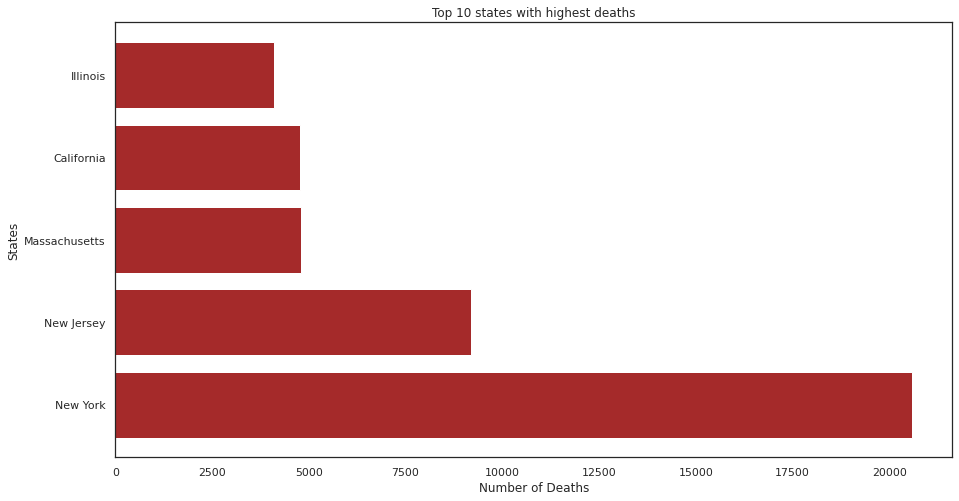

In [ ]:
dff = aa_10[::-1]
fig, ax = plt.subplots(figsize = (15,8))
ax.barh(aa_10['state'],aa_10['death_count'],color = 'brown')
plt.xlabel("Number of Deaths")
plt.ylabel("States")
plt.title("Top 10 states with highest deaths")

**Insight 9: The above graph shows that New York is having the highest number of deaths followed by New Jersey, Massachusetts and others.**

Analysis 10: What is the distribution of deaths in Top 5 states by month?

Assumption:Most of the days in the of april have higher deaths.Also,most days in Jun,Jul and Aug have lower deaths.We assume that it is the case with Top states which are having highest deaths 

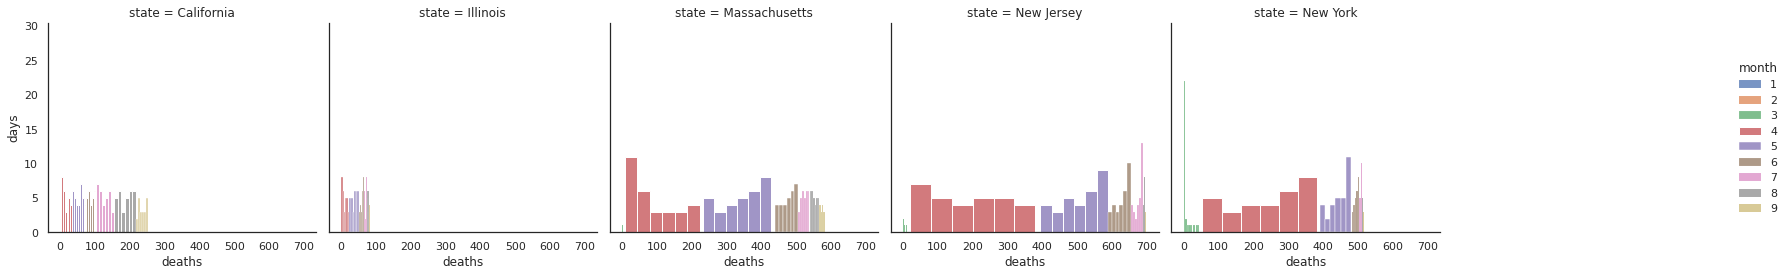

In [ ]:
df_covid_dist_top=pd.merge(dff,df_covid_merge,how='inner', left_on=['state'], right_on = ['state'])
df_covid_dist_top.head(5)
df_covid_dist=df_covid_dist_top.groupby(['state','county','date'],as_index=False).agg({'count': ['mean']})
df_covid_dist.columns = ['state','county','date','deaths_mean']
#df_covid_dist['diff']=df_covid_dist['deaths_mean'].diff()
df_covid_dist=df_covid_dist.groupby(['state','date'],as_index=False).agg({'deaths_mean': ['mean']})
df_covid_dist.columns = ['state','date','deaths_mean']
df_covid_dist['month']=df_covid_dist['date'].dt.month
#plot
g = sns.FacetGrid(df_covid_dist, col="state",hue='month',height=4, col_wrap=6)
g.map(sns.histplot, "deaths_mean")
g.add_legend()
g.set_axis_labels("deaths", "days")


**Insight 10 : 1.More number of days in New York,New Jersey states are having high in the months of March,April and May.**


Analysis 11: What are the top 3 counties which are having highest deaths in Top 10 states of USA?

Assumption: Urban counties may have higher death rates..

Text(0, 0.5, 'death cases')

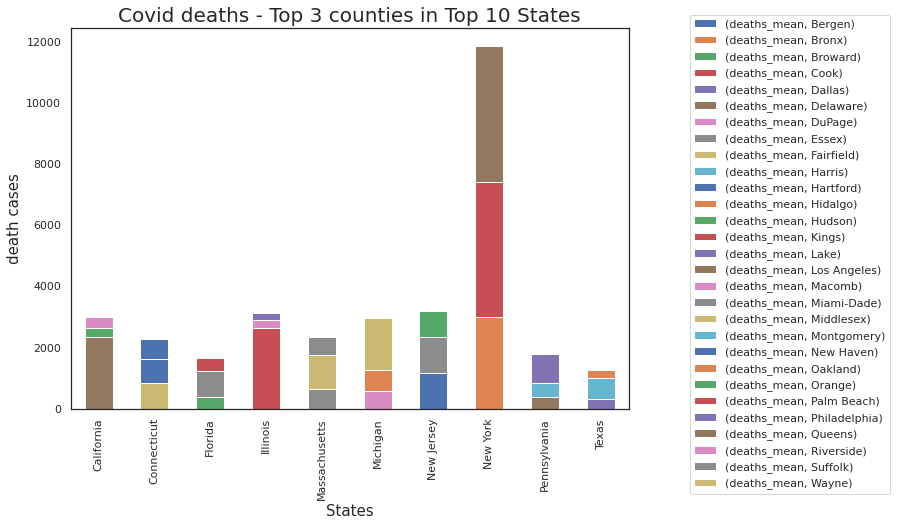

In [ ]:
df_covid_county=df_covid_merge.groupby(['state','county'],as_index=False).agg({'count': ['mean'],'population':['sum']})
df_covid_county.columns = ['state','county','deaths_mean', 'population']
df_covid_state_top10=df_covid_deaths_state.nlargest(10,'deaths')
df_covid_county=df_covid_county.sort_values('deaths_mean', ascending=False).groupby('state').head(3).sort_values(['state', 'deaths_mean'], ascending=False)
df_covid_county=pd.merge(df_covid_county,df_covid_state_top10,how='inner', left_on=['state'], right_on = ['state'])
df_covid_county=df_covid_county[['state','county','deaths_mean']]
pivot_df_covid_county = df_covid_county.pivot(index='state', columns='county')
pd.set_option('max_columns', None)
#print(pivot_df_covid_county)
ax = pivot_df_covid_county.plot.bar(stacked=True,figsize=(10,7))
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_title("Covid deaths - Top 3 counties in Top 10 States",size=20)
ax.set_xlabel("States",size=15)
ax.set_ylabel("death cases",size=15)

**Insight 11 : New York state had highest covid deaths till sep 2020.Bronx,Kings and Qeens counties of New York state are having higer covid death cases.**

Analysis 12: Look at the trips dataset and findout the trips distribution?

Assumption: As the deaths keep increasing we may notice a reduction in the number of trips

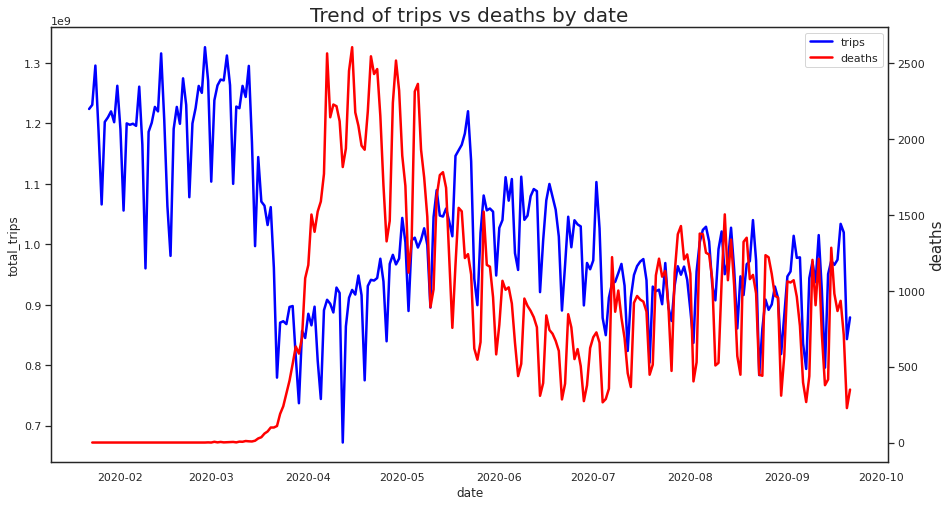

In [ ]:
#plot distributon of total number of trips across USA
df_trips_date=df_covid_merge.groupby(df_covid_merge['date'],as_index=False)['total_trips'].sum()
df_trips_date=pd.merge(df_trips_date,df_covid_date_tr,how='inner', left_on=['date'], right_on = ['date'])
#plt.figure(figsize=(15,8))
#plt.xticks(rotation=70)
a4_dims = (15, 8)
fig, ax = plt.subplots(figsize=a4_dims)
ax2 = ax.twinx()
sns.lineplot(data=df_trips_date, x="date", y="total_trips",color='blue', linewidth=2.5,ax=ax)
sns.lineplot(data=df_trips_date, x="date", y="diff",color='red', linewidth=2.5,ax=ax2)
plt.xlabel("date", size=15)
plt.ylabel("deaths", size=15)
plt.title("Trend of trips vs deaths by date",size=20)
#figsize=(15,8)
#plt_box.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
ax2.legend(handles=[a.lines[0] for a in [ax,ax2]], 
           labels=["trips", "deaths"])

**Insight 12: Above trend indicates there is sudden drop in the trips in months of March and April 2020 as the death count increased.This is inline with our assumption**

Analysis 13: Look at the trend of trips for top 10 states?

Assumption: Based on above insight,we may see reduction in the number of trips as the number of deaths increased even in the top 10 states

In [ ]:
#identify top 10 states
df_date_state=df_covid_date_state=pd.merge(dff,df_covid_merge,how='inner', left_on=['state'], right_on = ['state'])
df_covid_date_state=df_covid_date_state.groupby(df_date_state['date'],as_index=False)['count'].sum()
df_covid_date_state['diff']=df_covid_date_state['count'].diff()
df_trips_date_state=df_date_state.groupby(['date'],as_index=False)['total_trips'].sum()
df_trips_date_state=pd.merge(df_trips_date_state,df_covid_date_state,how='inner', left_on=['date'], right_on = ['date'])
#dff.head(20)

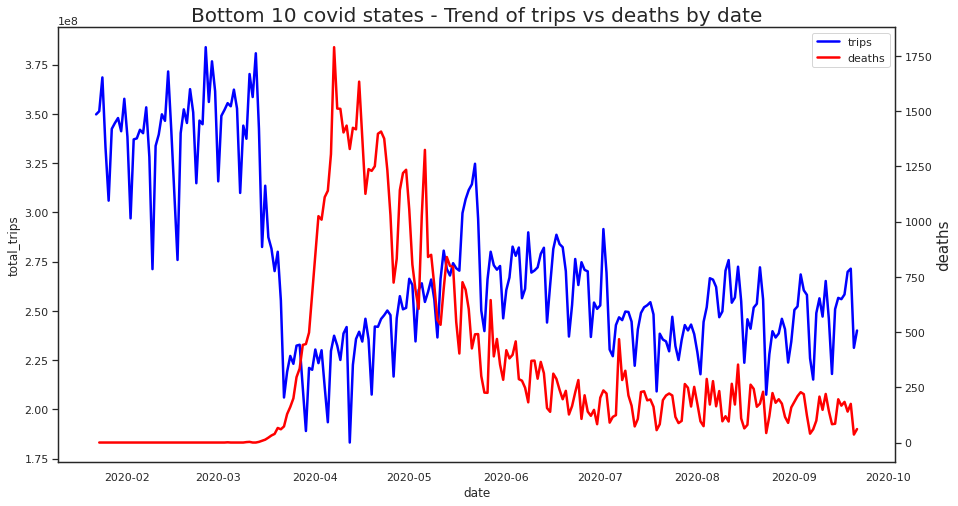

In [ ]:
##plot trend of trips and death counts for top 10 states
a4_dims = (15, 8)
fig, ax = plt.subplots(figsize=a4_dims)
ax2 = ax.twinx()
sns.lineplot(data=df_trips_date_state, x="date", y="total_trips",color='blue', linewidth=2.5,ax=ax)
sns.lineplot(data=df_trips_date_state, x="date", y="diff",color='red', linewidth=2.5,ax=ax2)
plt.xlabel("date", size=15)
plt.ylabel("deaths", size=15)
plt.title("Bottom 10 covid states - Trend of trips vs deaths by date",size=20)
#figsize=(15,8)
#plt_box.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
ax2.legend(handles=[a.lines[0] for a in [ax,ax2]], 
           labels=["trips", "deaths"])

**Insight 13: Top-10 states with highest death shows simillar trend of analysis as in Insight 12.**

Analysis 14 : What is the trend of states which are having less covid deaths?

Assumption: Simillar trend as seen in the above insights is expected in the states(bottom 10) which are having less number of covid deaths

In [ ]:

df_date_state_flop=df_covid_date_state=pd.merge(df_high_deats_bottom,df_covid_merge,how='inner', left_on=['state'], right_on = ['state'])
df_date_state_covid=df_covid_date_state.groupby(df_date_state_flop['date'],as_index=False)['count'].sum()
df_date_state_covid['deaths']=df_date_state_covid['count'].diff()
df_trips_date_state_flop=df_date_state_flop.groupby(['date'],as_index=False)['total_trips'].sum()
df_trips_date_state_flop=pd.merge(df_trips_date_state_flop,df_date_state_covid,how='inner', left_on=['date'], right_on = ['date'])
df_trips_date_state_flop.head(5)

date  total_trips  count  deaths
0 2020-01-22   16881369.0      0     NaN
1 2020-01-23   16658413.0      0     0.0
2 2020-01-24   17277347.0      0     0.0
3 2020-01-25   15472051.0      0     0.0
4 2020-01-26   14045387.0      0     0.0

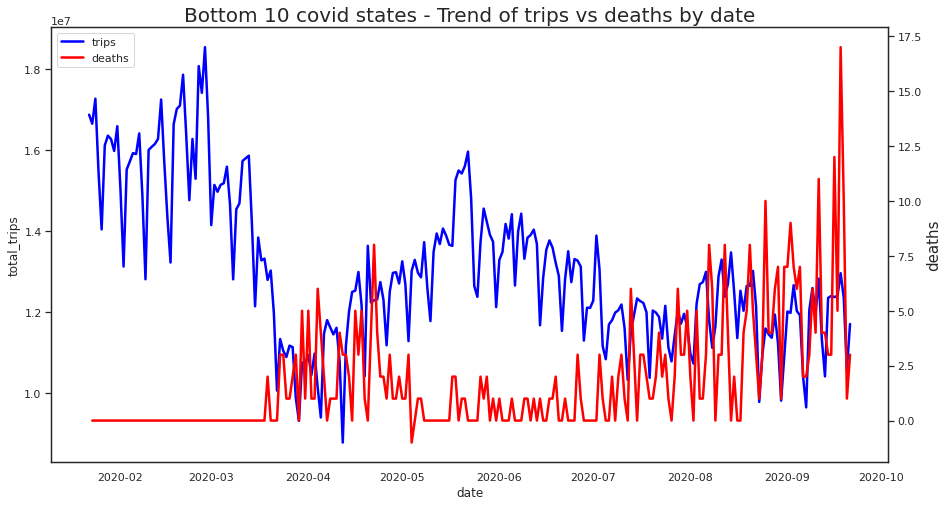

In [ ]:
##plot trend of trips and death counts for bottom 10 states
a4_dims = (15, 8)
fig, ax = plt.subplots(figsize=a4_dims)
ax2 = ax.twinx()
sns.lineplot(data=df_trips_date_state_flop, x="date", y="total_trips",color='blue', linewidth=2.5,ax=ax)
sns.lineplot(data=df_trips_date_state_flop, x="date", y="deaths",color='red', linewidth=2.5,ax=ax2)
plt.xlabel("date", size=15)
plt.ylabel("deaths", size=15)
plt.title("Bottom 10 covid states - Trend of trips vs deaths by date",size=20)
#figsize=(15,8)
#plt_box.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
ax2.legend(handles=[a.lines[0] for a in [ax,ax2]], 
           labels=["trips", "deaths"])

**Insight 14: Above analysis shows that the impact of high death rates in other states led to lower trips across states that saw lower overall death rates during the month of March and April.**

Analysis 15: Comparison across top 5 states on people who stayed at home vs who did not

Assumption: We may assume that more number of people may stay at home because of government guidelines.

In [ ]:
df_group = df_covid_merge[['state','count','pop_at_home','pop_not_home']]
df_group = df_group.groupby(['state'],as_index=False).agg({'count': 'sum','pop_at_home':'sum','pop_not_home':'sum'}).sort_values('count', ascending=False)
df_group['pop_at_home'] = df_group['pop_at_home'].astype(int)
df_group['pop_not_home'] = df_group['pop_not_home'].astype(int)

In [ ]:
df_group_1 = df_group[['state','pop_at_home','pop_not_home']]
df_group_1 = df_group_1.head()

Text(0.5, 1.0, 'Comparison of Top 5 states with people at home vs people who dint')

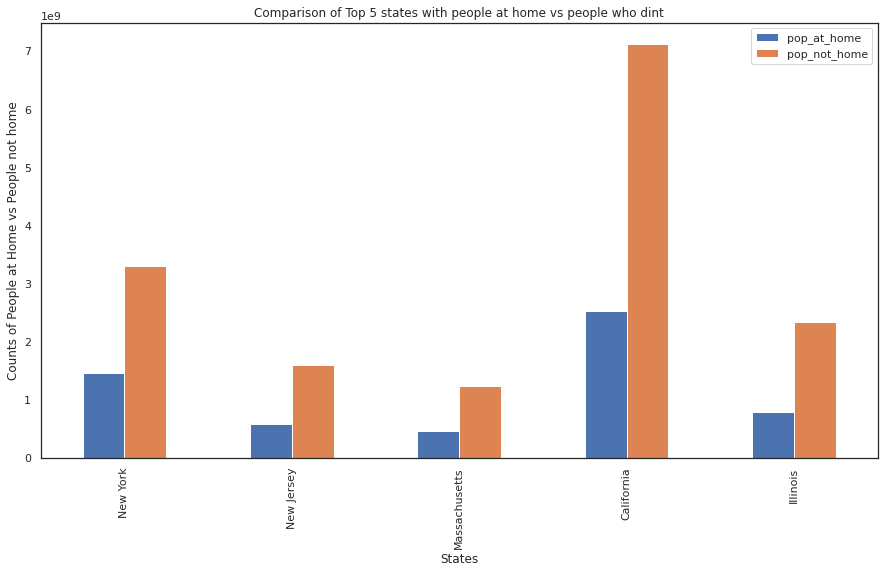

In [ ]:
df_group_1 = df_group_1.set_index('state')

df_group_1.plot(kind='bar',figsize = (15,8))
plt.xlabel("States")
plt.ylabel("Counts of People at Home vs People not home")
plt.title("Comparison of Top 5 states with people at home vs people who dint")

**Insight 15: Contrary to the assumption,We can see that in all the top 5 states the population count of  people who took trips are more than the people who actually stayed at home**

Insight 16: Comparison of trip length over period of 9 months

Assumption: Irrespective of length of the trips,we assume that there will be a reduction in all types of trips.

In [ ]:
df_mich = df_covid_merge[df_covid_merge['state'] == 'New York']
col_list = list(df_mich.columns.values.tolist())
edit_list = col_list[12:16]


In [ ]:
df_melt = df_mich.melt(id_vars = ['state','date','count','trips_dis_10_25','trips_dis_25_50','trips_dis_500'],value_vars =  edit_list,value_name= 'trips_dis_1_10')


In [ ]:
df_melt['month']=df_melt['date'].dt.month
#df_melt['month'].sort_values('month', ascending=True)

In [ ]:
df_melt = df_melt.groupby(['month'])['trips_dis_1_10','trips_dis_10_25','trips_dis_25_50','trips_dis_500'].sum().reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



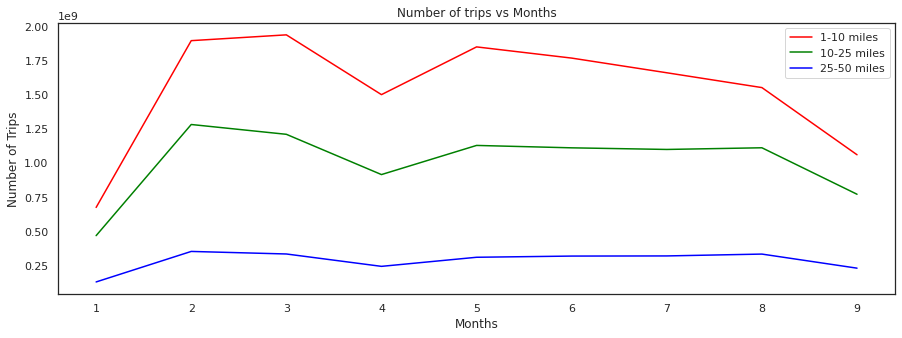

In [ ]:
plt.figure(figsize=(15, 5))
l1, = plt.plot(df_melt['month'], df_melt['trips_dis_1_10'],color='red')
l2, = plt.plot(df_melt['month'], df_melt['trips_dis_10_25'],color='green')
l3, = plt.plot(df_melt['month'], df_melt['trips_dis_25_50'], color='blue')
#plt.legend([l1, l2, l3])
plt.legend([l1, l2, l3], ['1-10 miles', '10-25 miles', '25-50 miles'])
plt.xlabel("Months")
plt.ylabel("Number of Trips")
 
plt.title('Number of trips vs Months')
plt.show()

**Insight 16: Above chart shows that there is a sudden drop in the shorter length of trips in the month of april compared to longer trips**

Analysis 17: What is the distribution of deaths in the state of New York's Top 5 counties?

Assumption: In the state of New York most densley populated county is New York.We assume that New York county will have highest number of deaths.

In [ ]:
df_mich_county = df_mich.groupby(['county'],as_index=False).agg({'count': 'sum'}).sort_values('count', ascending=False)
df_mich_county = df_mich_county.head()

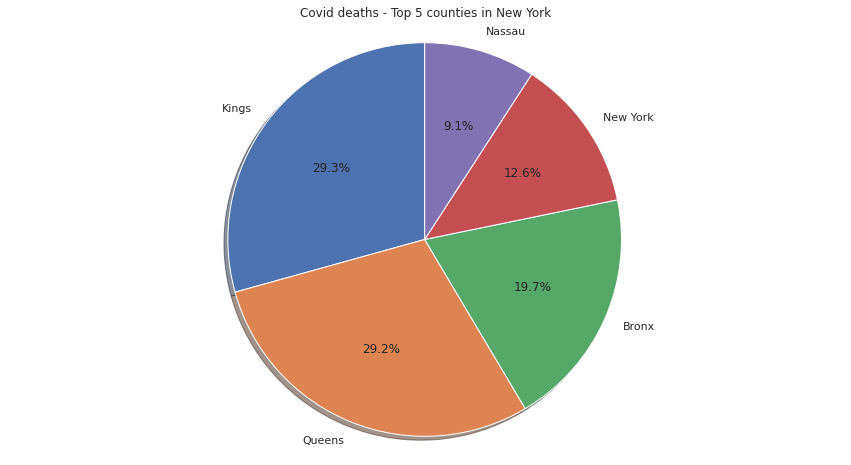

In [ ]:

a4_dims = (15, 8)
fig1, ax1 = plt.subplots(figsize=a4_dims)
labels = df_mich_county['county']
sizes = df_mich_county['count']

ax1.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Covid deaths - Top 5 counties in New York')
plt.show()


**Insight 17: Contrary to our assumption,Even though New York county is most densely populated and it only has 12% of deaths.Kings and Queens recorded highest deaths**

Analysis 18: Did more number of people in New York county stayed at home resulting in lower number of deaths?

Assumption: We assume that more number of people stayed at home in New York county

In [ ]:
df_mich_county_1 = df_mich.groupby(['county'],as_index=False).agg({'count': 'sum','pop_at_home':'sum','pop_not_home':'sum','population': 'sum'}).sort_values('count', ascending=False)
#df_mich_county_1 = df_mich_county_1[['county','pop_at_home','pop_not_home']]
df_mich_county_1.head()
df_mich_county_1 = df_mich_county_1.head()

In [ ]:
df_mich_county_1

county    count  pop_at_home  pop_not_home  population
23     Kings  1083636  234841230.0   395369290.0   624616332
41    Queens  1080327  184189767.0   371863297.0   549941352
2      Bronx   728097  137392736.0   212047472.0   346042508
30  New York   466611  188730057.0   208672987.0   397404264
29    Nassau   338092   87451502.0   243984190.0   331089456

In [ ]:
del df_mich_county_1['count']

Text(0.5, 1.0, 'Comparison of Top 5 countys in New York with people at home vs people who dint')

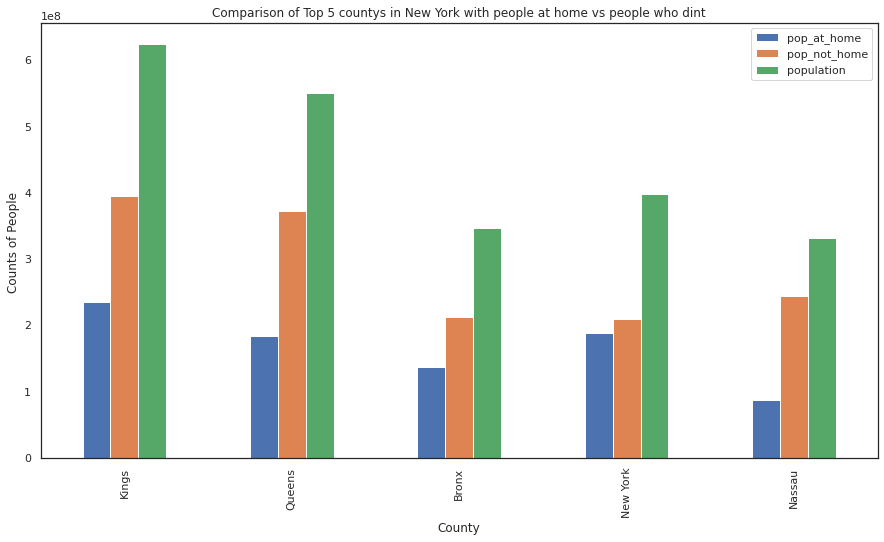

In [ ]:
df_mich_county_1 = df_mich_county_1.set_index('county')

df_mich_county_1.plot(kind='bar',figsize = (15,8))
plt.xlabel("County")
plt.ylabel("Counts of People ")
plt.title("Comparison of Top 5 countys in New York with people at home vs people who dint")

**Insight 18: The plot above shows that counties of Kings and Queens have the highest proportion of population not at home and hence the highest death rates (as seen from plot above).**
**Another point to note is that the proportion of people who stayed at home vs who did not, is better in New York county resulting in lesser number of deaths.**

Analysis 19: Look at the correlations of **all** variables of both the datasets?

Assumption: We assume that above insights align with the correlation matrix of the datasets.

Text(0.5, 1.08, 'Overall Correlation of all variables')

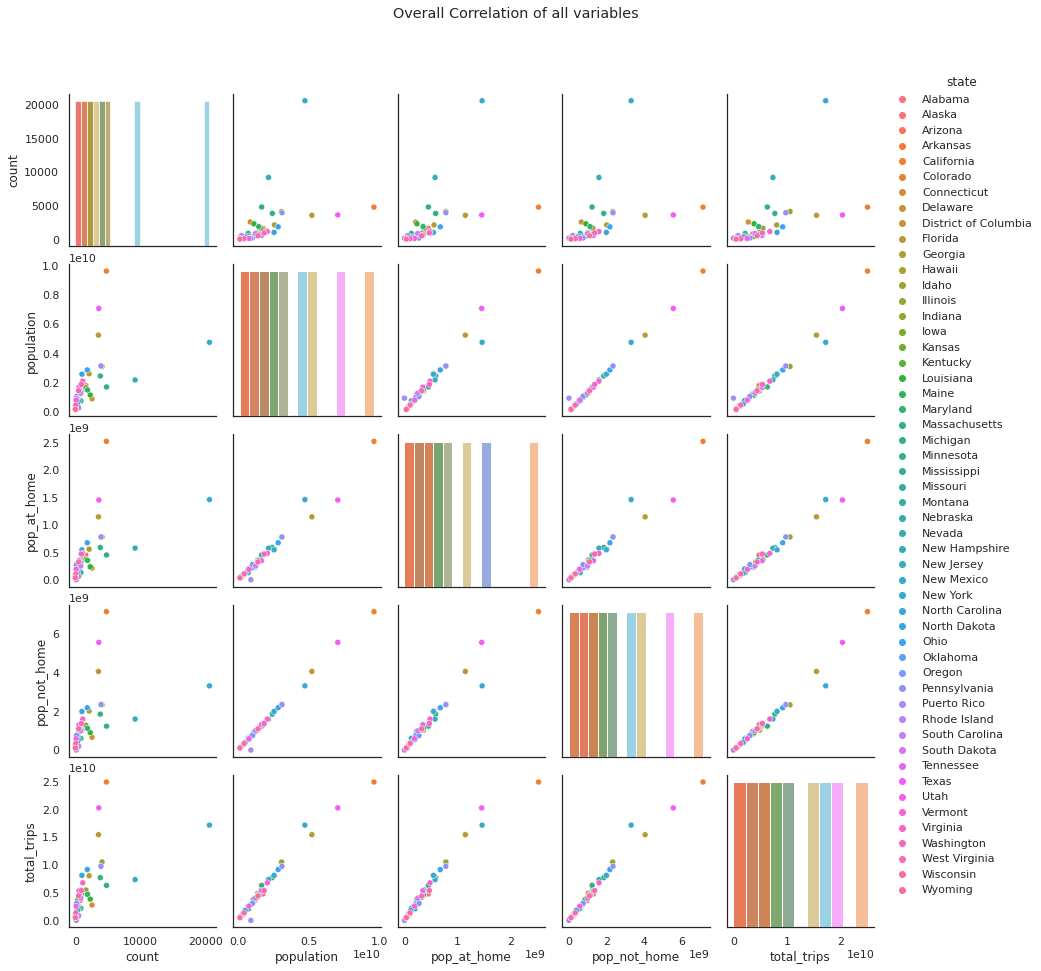

In [ ]:
#df_covid_merge.info()
df_covid_trips_hist=df_covid_merge.groupby(['state','county'],as_index=False).agg({'count': ['mean'],'population':['sum'],'pop_at_home':['sum'],'pop_not_home':['sum'],'total_trips':['sum']})
df_covid_trips_hist.columns=['state','county','count','population','pop_at_home','pop_not_home','total_trips']
df_covid_trips_hist=df_covid_trips_hist.groupby(['state'],as_index=False).agg({'count': ['sum'],'population':['sum'],'pop_at_home':['sum'],'pop_not_home':['sum'],'total_trips':['sum']})
df_covid_trips_hist.columns=['state','count','population','pop_at_home','pop_not_home','total_trips']
g=sns.pairplot(df_covid_trips_hist, hue="state",diag_kind="hist")
g.fig.suptitle("Overall Correlation of all variables", y=1.08)

**Insight 19: Correlation plots shows number of deaths increased slightly as number of trips increases.This is kind of aligned with analysis in above plots.**

Analysis 20: Of the States with most number of trips (by total distance), how is the distribution across distance buckets.

Assumption:We assume that longer trips count will reduce during covid

In [ ]:
top5_death = df_covid_merge.groupby(['state'],as_index=False).agg({'count': 'sum','pop_not_home': 'sum','pop_at_home': 'sum'}).sort_values('count', ascending=False)
top5_death['pop_not_home'] = top5_death['pop_not_home'].astype(int)
top5_death['pop_at_home'] = top5_death['pop_at_home'].astype(int)
top5_death = top5_death.head()
top5_death.head()

state    count  pop_not_home  pop_at_home
32       New York  5025781    3306980098   1461318898
30     New Jersey  2239544    1597364243    576314637
21  Massachusetts  1168470    1232911614    451212742
4      California  1163974    7129368991   2522480493
13       Illinois  1001886    2328870920    779952600

In [ ]:
tripsmerge = df_trips_people_20.groupby(['state_nm'],as_index=True).agg({'total_trips': 'sum', 'trips_dis_1': 'sum','trips_dis_1_3': 'sum','trips_dis_3_5': 'sum',
                                                                          'trips_dis_5_10': 'sum', 'trips_dis_10_25': 'sum', 'trips_dis_25_50': 'sum', 
                                                                          'trips_dis_50_100': 'sum', 'trips_dis_100_250': 'sum',
                                                                          'trips_dis_250_500': 'sum', 'trips_dis_500': 'sum'}
                                                                         ).sort_values('total_trips', ascending=False)


tripsmerge.head(5)

total_trips   trips_dis_1  trips_dis_1_3  trips_dis_3_5  \
state_nm                                                             
CA        3.216959e+10  8.460797e+09   8.081789e+09   3.684390e+09   
TX        2.591338e+10  6.346979e+09   6.429294e+09   3.083179e+09   
NY        2.186811e+10  6.337610e+09   5.460005e+09   2.605782e+09   
FL        1.977551e+10  5.050008e+09   5.026575e+09   2.532610e+09   
IL        1.343489e+10  3.570210e+09   3.315395e+09   1.571989e+09   

          trips_dis_5_10  trips_dis_10_25  trips_dis_25_50  trips_dis_50_100  \
state_nm                                                                       
CA          4.516778e+09     4.558477e+09     1.819633e+09       699987671.0   
TX          3.860260e+09     3.940131e+09     1.421315e+09       504174583.0   
NY          3.262223e+09     2.934651e+09     8.246988e+08       285041631.0   
FL          3.105183e+09     2.755619e+09     8.464647e+08       276138772.0   
IL          1.949171e+09     1.957166e+09     7.164165e+08       205920824.0   

          trips_dis_100_250  trips_dis_250_500  trips_dis_500  
state_nm                                                       
CA              257640524.0         57076987.0     33019741.0  
TX              243444346.0         57486097.0     27118075.0  
NY              110070778.0         21942101.0     26087706.0  
FL              130690364.0         30481281.0     21740192.0  
IL              105512349.0         27282395.0     15828943.0

Text(0, 0.5, '# of Trips')

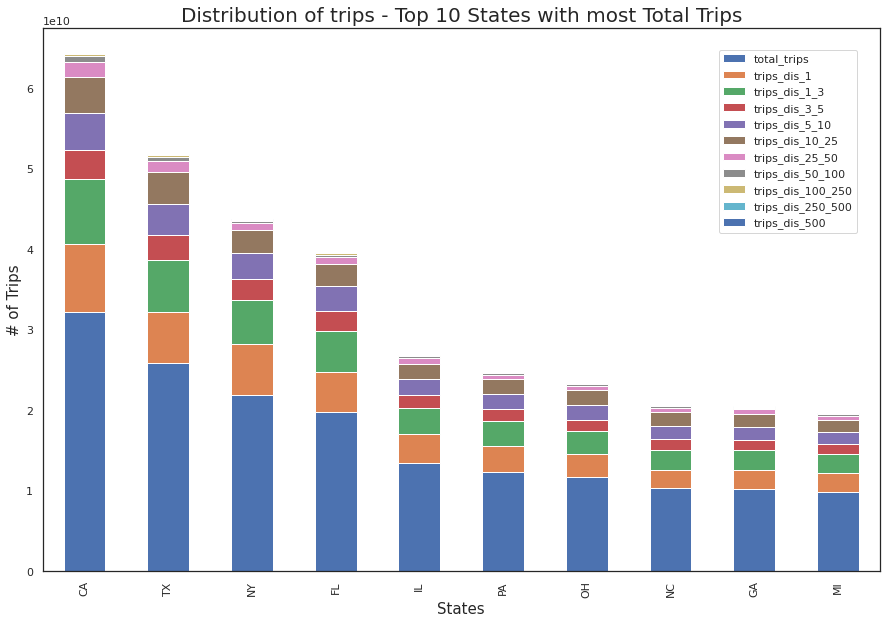

In [ ]:
tripsmerge1=tripsmerge.nlargest(10,'total_trips')
ax1 = tripsmerge1.plot.bar(stacked=True,figsize=(15,10))
ax1.legend(bbox_to_anchor=(0.98, .97))
ax1.set_title("Distribution of trips - Top 10 States with most Total Trips",size=20)
ax1.set_xlabel("States",size=15)
ax1.set_ylabel("# of Trips",size=15)

**Insight #20: From the above plot, its evident that during Covid time, across States, there were almost no long distance trips made by people. Most of the trips were within the 100 mile range.**

# Conclusion & Insights
In conclusion, we performed detailed analysis of two key datasets: one with information on number of people staying at home vs on the move, while the other providing number of Covid related deaths by date. Both datasets centered around different counties across states in USA. 
The reason for our selection of these two datasets was mainly to assess the impact of spread of Covid on people's mobility and monitor any trends as duration of the pandemic increases and extends to last quarter of 2020.
Following key insights were inferred by our team:
1. The states of New York, California and Illinois were among the highest for Covid related deaths, during the months of Jan thru Sep of 2020. They were also among the to 5 which had higher population of people on the move. 
2. The overall movement of people were drastically reduced as the number of Covid deaths spiked during the month of Mar and April of 2020. However, it can also be seen that for the second (less severe) spike, during months of July and August, people did not stay put and were relatively mobile.
3.Further analysis showed that staying at home resulted in lesser covid deaths as seen in New York county
4.Another interesting insight is that the number of shorter trips reduced drastically however this trend is not observed with trips ranging over 50 miles.
5.The analysis also showed that there is no correlation between the population  and deaths across USA.